退学率 (Dummy Data): 0.8%


,Student_ID,GPA_1st_Year,Attendance_Rate,PartTime_Hours,Financial_Aid,Dropout_Flag
0,1,2.798028,1.000000,8.248217,1,0
1,2,2.417041,0.988695,13.554813,1,0
2,3,2.888613,0.858945,7.075801,0,0
3,4,3.413818,0.752959,11.920385,1,0
4,5,2.359508,0.954733,0.000000,0,0



=== リスク要因分析 (Risk Factors) ===
オッズ比 > 1 ならリスク増、< 1 ならリスク減を表す


,Feature,Coefficient,Odds Ratio (Risk Multiplier)
2,PartTime_Hours,0.100140,1.105325
3,Financial_Aid,-0.449311,0.638068
1,Attendance_Rate,-0.657203,0.518299
0,GPA_1st_Year,-1.691129,0.184311



=== 精度評価レポート ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       198
           1       0.00      0.00      0.00         2

    accuracy                           0.99       200
   macro avg       0.49      0.50      0.50       200
weighted avg       0.98      0.99      0.99       200



c:\Users\USER\miniconda3\envs\ir_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\miniconda3\envs\ir_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\USER\miniconda3\envs\ir_project\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

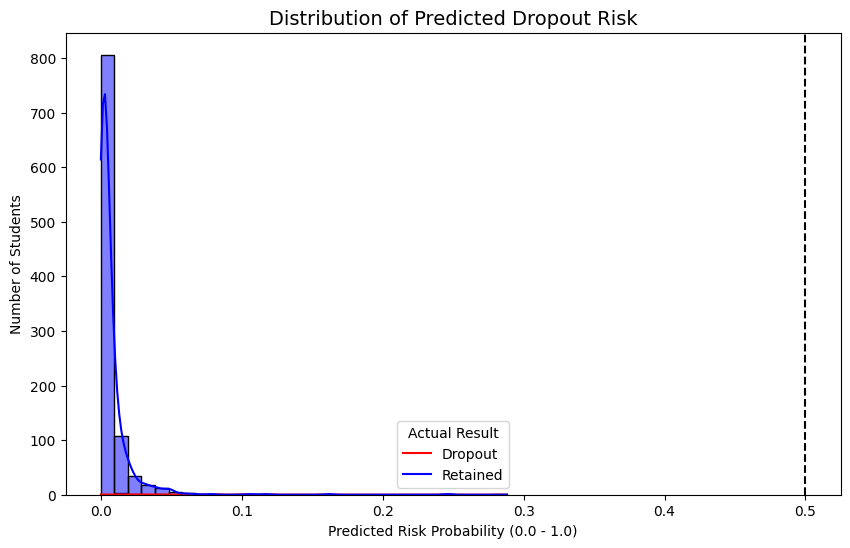


=== 要支援学生リスト (Risk > 70%) : 0名 ===


,Student_ID,GPA_1st_Year,Attendance_Rate,PartTime_Hours,Financial_Aid,Dropout_Flag,Predicted_Risk


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# ■ 退学予兆検知モデル (Early Warning System using Logistic Regression)
# 目的: 学生の行動データから「退学リスク」を早期に予測し、介入の優先順位をつける。

# ----------------------------------------------------------
# 1. ダミーデータの生成 (Data Generation)
# ----------------------------------------------------------
# IRの実務でよく使われる変数を想定して、学生1,000人分のデータを生成
np.random.seed(42)
n_students = 1000

data = {
    'Student_ID': range(1, n_students + 1),
    # 1年次GPA (0.0 - 4.0)
    'GPA_1st_Year': np.random.normal(2.5, 0.6, n_students).clip(0, 4.0),
    # 出席率 (0% - 100%)
    'Attendance_Rate': np.random.normal(0.85, 0.15, n_students).clip(0, 1.0),
    # 週アルバイト時間 (0 - 40時間)
    'PartTime_Hours': np.random.normal(15, 10, n_students).clip(0, 40),
    # 経済支援 (あり=1, なし=0)
    'Financial_Aid': np.random.choice([0, 1], n_students, p=[0.7, 0.3]),
}

df = pd.DataFrame(data)

# 退学フラグ (Target) の生成ロジック
# GPAが低く、出席率が悪く、バイト時間が長いほど退学しやすい確率モデルにする
logits = (
    -2.0 * df['GPA_1st_Year'] +       # GPAが高いほどリスク減
    -3.5 * df['Attendance_Rate'] +    # 出席率が高いほどリスク減
    0.08 * df['PartTime_Hours'] +     # バイトが長いほどリスク増
    -0.5 * df['Financial_Aid'] +      # 支援があるとリスク微減
    1.5                               # 切片
)
probabilities = 1 / (1 + np.exp(-logits))
df['Dropout_Flag'] = np.random.binomial(1, probabilities)

print(f"退学率 (Dummy Data): {df['Dropout_Flag'].mean():.1%}")
display(df.head())

# ----------------------------------------------------------
# 2. ロジスティック回帰モデルの構築 (Modeling)
# ----------------------------------------------------------
# 説明変数 (X) と 目的変数 (y)
X = df[['GPA_1st_Year', 'Attendance_Rate', 'PartTime_Hours', 'Financial_Aid']]
y = df['Dropout_Flag']

# 学習データとテストデータに分割 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル学習
model = LogisticRegression()
model.fit(X_train, y_train)

# ----------------------------------------------------------
# 3. 分析結果とリスク要因の特定 (Evaluation)
# ----------------------------------------------------------
# 係数（オッズ比）の確認
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0],
    'Odds Ratio (Risk Multiplier)': np.exp(model.coef_[0])
}).sort_values('Coefficient', ascending=False)

print("\n=== リスク要因分析 (Risk Factors) ===")
print("オッズ比 > 1 ならリスク増、< 1 ならリスク減を表す")
display(coef_df)

# テストデータでの予測精度
y_pred = model.predict(X_test)
print("\n=== 精度評価レポート ===")
print(classification_report(y_test, y_pred))

# ----------------------------------------------------------
# 4. 可視化: 退学確率の分布 (Risk Distribution)
# ----------------------------------------------------------
# 全学生の退学確率を予測
df['Predicted_Risk'] = model.predict_proba(X)[:, 1]

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Predicted_Risk', hue='Dropout_Flag', bins=30, kde=True, palette={0: 'blue', 1: 'red'})
plt.title('Distribution of Predicted Dropout Risk', fontsize=14)
plt.xlabel('Predicted Risk Probability (0.0 - 1.0)')
plt.ylabel('Number of Students')
plt.legend(title='Actual Result', labels=['Dropout', 'Retained'])
plt.axvline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.show()

# ----------------------------------------------------------
# 5. IR実務への応用: 「ハイリスク学生」リストの抽出
# ----------------------------------------------------------
# リスクが70%を超える学生を抽出（面談推奨リスト）
high_risk_students = df[df['Predicted_Risk'] > 0.7].sort_values('Predicted_Risk', ascending=False)
print(f"\n=== 要支援学生リスト (Risk > 70%) : {len(high_risk_students)}名 ===")
display(high_risk_students.head(5))